# The Bird Brains

## Imports

In [ ]:
import cudf
import cupy as cp
import numpy as np
import numba
from cuml.ensemble import RandomForestClassifier
from cuml.cluster import KMeans as cuKMeans
from cuml.preprocessing import StandardScaler as cuStandardScaler
from cuml.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import joblib
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

## Preprocessing

In [ ]:
file_path = "Anas_platyrhynchos_cleaned.csv"
df = cudf.read_csv(file_path)
df.head()

,SCIENTIFIC NAME,OBSERVATION COUNT,COUNTRY,STATE,COUNTY,LATITUDE,LONGITUDE,OBSERVATION DATE,PROTOCOL TYPE,PROTOCOL CODE,PROJECT CODE,NUMBER OBSERVERS,YEAR,MONTH,DAY,DAY_OF_WEEK,DAY OF YEAR
0,Limosa lapponica,X,Australia,Western Australia,Broome,-17.977440,122.345510,2010-04-20T00:00:00.000000000Z,Stationary,P21,EBIRD,2,2010,4,20,1,110
1,Limosa lapponica,10,Japan,Chiba,Narashino,35.677919,140.005281,2010-08-06T00:00:00.000000000Z,Stationary,P21,EBIRD,1,2010,8,6,4,218
2,Limosa lapponica,3,Malaysia,Perak,<NA>,4.430000,100.621167,2010-02-11T00:00:00.000000000Z,Historical,P62,EBIRD,2,2010,2,11,3,42
3,Limosa lapponica,30,Netherlands,Fryslân,<NA>,53.270263,4.985669,2010-09-19T00:00:00.000000000Z,Historical,P62,EBIRD,<NA>,2010,9,19,6,262
4,Limosa lapponica,6,Spain,Cataluña,Tarragona,40.762455,0.798097,2010-12-12T00:00:00.000000000Z,Stationary,P21,EBIRD,1,2010,12,12,6,346


## Filtering
Filtering for the year 2020-2024

In [ ]:
df = df[(df['YEAR'] >= 2020) & (df['YEAR'] <= 2024)]
df = df[df['OBSERVATION COUNT'].str.contains('X') == False]
df['OBSERVATION COUNT'] = df['OBSERVATION COUNT'].astype('int32')
df = df[df['COUNTRY'].isin(['United States', 'Mexico', 'Canada'])]
len(df)

9362

In [ ]:
df['SEASON'] = 0  # Initialize column

df.loc[df['MONTH'].isin([12, 1, 2]), 'SEASON'] = 1  # Winter
df.loc[df['MONTH'].isin([3, 4, 5]), 'SEASON'] = 2  # Spring
df.loc[df['MONTH'].isin([6, 7, 8]), 'SEASON'] = 3  # Summer
df.loc[df['MONTH'].isin([9, 10, 11]), 'SEASON'] = 4  # Fall
df.head()

df_pd = df.to_pandas()

seasons = df_pd['SEASON'].unique()

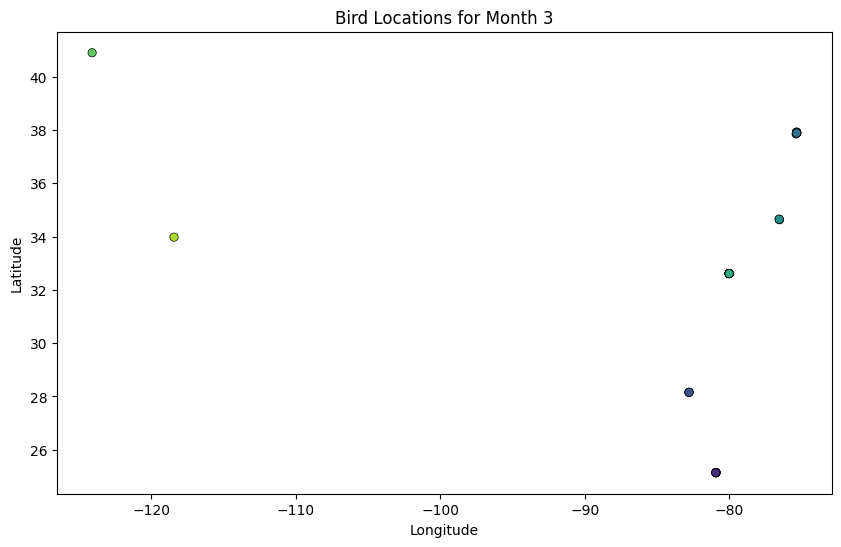

In [ ]:
def filter_by_month(month):

    # Filter data for the specific month
    month_data = df[df['MONTH'] == month]

    # Convert the filtered data to pandas for plotting
    month_data_pd = month_data.to_pandas()

    # Plotting the data for the selected month
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x=month_data_pd['LONGITUDE'],
        y=month_data_pd['LATITUDE'],
        hue=month_data_pd['COUNTY'],
        palette='viridis',
        edgecolor='black',
        legend=False
    )

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"Bird Locations for Month {month}")
    plt.show()

filter_by_month(3) #(1 to 12)

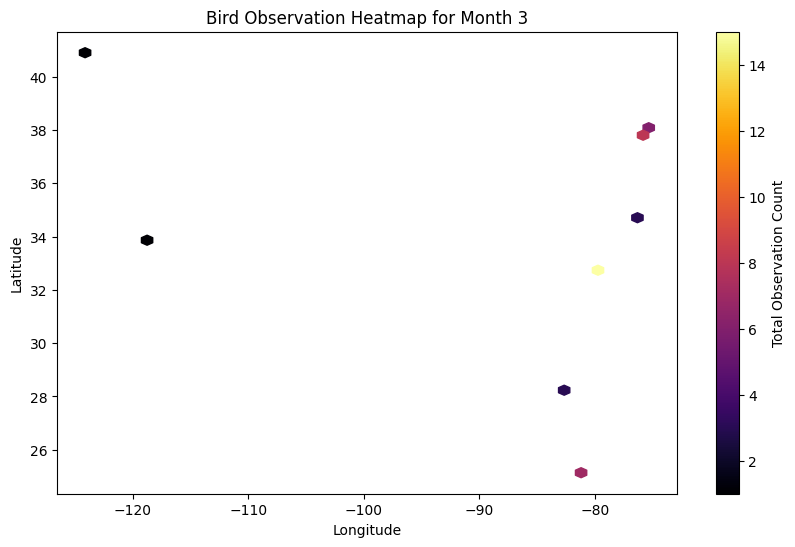

In [ ]:


def filter_by_month_heatmap(month):
    # Filter data for the specific month and day
    month_data = df[(df['MONTH'] == month)]

    # Convert to pandas for plotting
    month_data_pd = month_data.to_pandas()

    # Create heatmap using hexbin
    plt.figure(figsize=(10, 6))
    hb = plt.hexbin(
        month_data_pd['LONGITUDE'],
        month_data_pd['LATITUDE'],
        C=month_data_pd['OBSERVATION COUNT'],
        gridsize=50,  # Adjust for resolution
        cmap='inferno',
        reduce_C_function=np.sum
    )

    plt.colorbar(hb, label='Total Observation Count')
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"Bird Observation Heatmap for Month {month}")
    plt.show()

# Example: Generate heatmap for March (3)
filter_by_month_heatmap(3)

## Training

In [ ]:
df["county_encoded"] = df["COUNTY"].factorize()[0]
df["state_encoded"] = df["STATE"].factorize()[0]


In [ ]:
X = df[["DAY OF YEAR", "YEAR", "LATITUDE", "LONGITUDE", "county_encoded", "state_encoded"]]
y = df["OBSERVATION COUNT"]

bins = [0, 10, 100, cp.inf]
labels = [0, 1, 2]  # 0=low, 1=medium, 2=high
df["density_class"] = cudf.cut(y, bins=bins, labels=labels).astype("int32")
y = df["density_class"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/home/jojara/.local/lib/python3.10/site-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.to_pandas())
X_test_scaled = scaler.transform(X_test.to_pandas())


In [ ]:
X_train_torch = torch.tensor(X_train_scaled, dtype=torch.float32).cuda()
X_test_torch = torch.tensor(X_test_scaled, dtype=torch.float32).cuda()
y_train_torch = torch.tensor(y_train.to_numpy(), dtype=torch.long).cuda()
y_test_torch = torch.tensor(y_test.to_numpy(), dtype=torch.long).cuda()

In [ ]:
class BirdNN(nn.Module):
    def __init__(self):
        super(BirdNN, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 3)  # 3 density classes

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


In [ ]:
# Train Neural Network
print("Training Neural Network with CUDA...")
model = BirdNN().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Training Neural Network with CUDA...


In [ ]:
for epoch in range(300):
    optimizer.zero_grad()
    outputs = model(X_train_torch)
    loss = criterion(outputs, y_train_torch)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 0.1459
Epoch 2, Loss: 0.1459
Epoch 3, Loss: 0.1459
Epoch 4, Loss: 0.1458
Epoch 5, Loss: 0.1458
Epoch 6, Loss: 0.1458
Epoch 7, Loss: 0.1458
Epoch 8, Loss: 0.1457
Epoch 9, Loss: 0.1457
Epoch 10, Loss: 0.1457
Epoch 11, Loss: 0.1457
Epoch 12, Loss: 0.1457
Epoch 13, Loss: 0.1456
Epoch 14, Loss: 0.1456
Epoch 15, Loss: 0.1456
Epoch 16, Loss: 0.1456
Epoch 17, Loss: 0.1456
Epoch 18, Loss: 0.1455
Epoch 19, Loss: 0.1455
Epoch 20, Loss: 0.1455
Epoch 21, Loss: 0.1455
Epoch 22, Loss: 0.1454
Epoch 23, Loss: 0.1454
Epoch 24, Loss: 0.1454
Epoch 25, Loss: 0.1454
Epoch 26, Loss: 0.1454
Epoch 27, Loss: 0.1453
Epoch 28, Loss: 0.1453
Epoch 29, Loss: 0.1453
Epoch 30, Loss: 0.1453
Epoch 31, Loss: 0.1453
Epoch 32, Loss: 0.1452
Epoch 33, Loss: 0.1452
Epoch 34, Loss: 0.1452
Epoch 35, Loss: 0.1452
Epoch 36, Loss: 0.1451
Epoch 37, Loss: 0.1451
Epoch 38, Loss: 0.1451
Epoch 39, Loss: 0.1451
Epoch 40, Loss: 0.1451
Epoch 41, Loss: 0.1450
Epoch 42, Loss: 0.1450
Epoch 43, Loss: 0.1450
Epoch 44, Loss: 0.14

In [ ]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_torch)
    _, predicted = torch.max(test_outputs, 1)
    accuracy = (predicted == y_test_torch).float().mean().item()
    print("Neural Network Accuracy:", accuracy)

Neural Network Accuracy: 0.9530165791511536


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

historical_date = {"DAY OF YEAR": 74, "YEAR": 2023}  # March 15

# Filter for relevant locations
historical_data = df[(df["DAY OF YEAR"] == historical_date["DAY OF YEAR"]) & (df["YEAR"] == historical_date["YEAR"])]

if historical_data.empty:
    print("No historical data available for this date.")
else:
    # Prepare input features
    X_historical = historical_data[["DAY OF YEAR", "YEAR", "LATITUDE", "LONGITUDE", "county_encoded", "state_encoded"]]

    # Scale the features
    X_historical_scaled = scaler.transform(X_historical.to_pandas())

    # Convert to CUDA tensors
    X_historical_torch = torch.tensor(X_historical_scaled, dtype=torch.float32).cuda()

    # Make predictions
    model.eval()
    with torch.no_grad():
        predictions = model(X_historical_torch)
        _, predicted_classes = torch.max(predictions, 1)

    historical_data["Predicted Density"] = predicted_classes.cpu().numpy()

    # Visualization
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x=historical_data["LONGITUDE"].to_pandas(),
        y=historical_data["LATITUDE"].to_pandas(),
        hue=historical_data["Predicted Density"].to_pandas(),
        palette="coolwarm",
        edgecolor="black"
    )
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"Predicted Bird Density on {historical_date['YEAR']}-03-15")
    plt.legend(title="Density (0=Low, 1=Medium, 2=High)")
    plt.show()


No historical data available for this date.


Predicted Bird Density for 2025-03-15: Low


/home/jojara/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
